# Compute Graph of Countries and their Relationships

Author: Dr. Klaus G. Paul, Rolls-Royce Deutschland, R²Data Labs, Berlin AI Hub, klaus.paul(at)rolls-royce.com

This notebook forms the basis for the data flow in the emergent engine, the simulation and what-if framework for the ALOHA project.

We were balancing tools and packages to use and opted for a minimum prerequisite, standard libary, NetworkX based approach. Graph databases would offer a more elegant way, semantic notations a better integration.

Attempts are made to follow approaches used by schema.org, in particular, https://schema.org/Country

In [23]:
from pathlib import Path
import requests
import io
import os
import zipfile
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import json
from IPython.display import display
import pandas as pd
import time

Download data files. You may want to consider commenting this out once you downloaded it.

In [13]:
Path("/project_data/data_asset/sun/geo/naturalearthdata.com_downloads").mkdir(parents=True, exist_ok=True)

r = requests.get("https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_sovereignty.zip")
with zipfile.ZipFile(io.BytesIO(r.content),"r") as zf:
    zf.extractall("/project_data/data_asset/sun/geo/naturalearthdata.com_downloads")
    
r = requests.get("https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip")
with zipfile.ZipFile(io.BytesIO(r.content),"r") as zf:
    zf.extractall("/project_data/data_asset/sun/geo/naturalearthdata.com_downloads")
    
r = requests.get("https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_map_units.zip")
with zipfile.ZipFile(io.BytesIO(r.content),"r") as zf:
    zf.extractall("/project_data/data_asset/sun/geo/naturalearthdata.com_downloads")
    

In [12]:
os.listdir("/project_data/data_asset/sun/geo/naturalearthdata.com_downloads")

['ne_10m_admin_0_countries.README.html',
 'ne_10m_admin_0_countries.VERSION.txt',
 'ne_10m_admin_0_countries.cpg',
 'ne_10m_admin_0_countries.dbf',
 'ne_10m_admin_0_countries.prj',
 'ne_10m_admin_0_countries.shp',
 'ne_10m_admin_0_countries.shx',
 'ne_10m_admin_0_sovereignty.README.html',
 'ne_10m_admin_0_sovereignty.VERSION.txt',
 'ne_10m_admin_0_sovereignty.cpg',
 'ne_10m_admin_0_sovereignty.dbf',
 'ne_10m_admin_0_sovereignty.prj',
 'ne_10m_admin_0_sovereignty.shp',
 'ne_10m_admin_0_sovereignty.shx',
 'ne_10m_admin_0_boundary_lines_map_units.README.html',
 'ne_10m_admin_0_boundary_lines_map_units.VERSION.txt',
 'ne_10m_admin_0_boundary_lines_map_units.cpg',
 'ne_10m_admin_0_boundary_lines_map_units.dbf',
 'ne_10m_admin_0_boundary_lines_map_units.prj',
 'ne_10m_admin_0_boundary_lines_map_units.shp',
 'ne_10m_admin_0_boundary_lines_map_units.shx']

In [14]:
worlddata = gpd.read_file("/project_data/data_asset/sun/geo/naturalearthdata.com_downloads/ne_10m_admin_0_countries.shp")
sovereignitydata = gpd.read_file("/project_data/data_asset/sun/geo/naturalearthdata.com_downloads/ne_10m_admin_0_sovereignty.shp")
map_unitsdata = gpd.read_file("/project_data/data_asset/sun/geo/naturalearthdata.com_downloads/ne_10m_admin_0_map_units.shp")

In [16]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    #display(worlddata.iloc[0].transpose())
    display(map_unitsdata.iloc[24].transpose()) # Display French Guiana

featurecla                                     Admin-0 map unit
scalerank                                                     0
LABELRANK                                                     4
SOVEREIGNT                                               France
SOV_A3                                                      FR1
ADM0_DIF                                                      1
LEVEL                                                         3
TYPE                                                   Geo unit
ADMIN                                                    France
ADM0_A3                                                     FRA
GEOU_DIF                                                      1
GEOUNIT                                           French Guiana
GU_A3                                                       GUF
SU_DIF                                                        0
SUBUNIT                                           French Guiana
SU_A3                                   

In [17]:
# this needs sorting out
dfTmp = pd.DataFrame(map_unitsdata[["NAME","ADM0_A3"]].groupby("ADM0_A3").size())
l = list(dfTmp[dfTmp[0]>1].index)
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    ddf = map_unitsdata[map_unitsdata.ISO_A3 == "-99"]
    display(ddf[["NAME","NAME_EN","ADM0_A3","SOV_A3","ISO_A3"]][ddf.ADM0_A3.isin(l)].sort_values("ADM0_A3"))

,NAME,NAME_EN,ADM0_A3,SOV_A3,ISO_A3
222,Antigua,Antigua,ATG,ATG,-99
224,Barbuda,Barbuda,ATG,ATG,-99
187,Brussels,Brussels-Capital Region,BEL,BEL,-99
64,Flemish,Flemish Brabant,BEL,BEL,-99
65,Walloon,Walloon Brabant,BEL,BEL,-99
149,Brcko District,Brčko District,BIH,BIH,-99
140,Rep. Srpska,Republika Srpska,BIH,BIH,-99
139,Fed. of Bos. & Herz.,Federation of Bosnia and Herzegovina,BIH,BIH,-99
275,Paracel Is.,Paracel Islands,CHN,CH1,-99
185,England,England,GBR,GB1,-99


In [18]:
def find_node_by_attribute_value(graph,attribute,value,kind=""):
    for n,d in graph.nodes(data=True):
        if attribute not in d.keys():
            continue
        elif kind != "":
            if d[attribute] == value and d["kind"] == kind:
                retval = n
                break
        else:
            if d[attribute] == value:
                retval = n
                break
    else:
        retval = None
        
    return retval

In [19]:
worlddata.REGION_UN.unique()

array(['Asia', 'Americas', 'Africa', 'Europe', 'Oceania', 'Antarctica',
       'Seven seas (open ocean)'], dtype=object)

In [20]:
worlddata[["REGION_UN","SUBREGION"]].drop_duplicates()

,REGION_UN,SUBREGION
0,Asia,South-Eastern Asia
2,Americas,South America
6,Asia,Western Asia
8,Asia,Southern Asia
9,Asia,Eastern Asia
13,Africa,Eastern Africa
22,Europe,Western Europe
27,Africa,Northern Africa
29,Americas,Central America
31,Africa,Middle Africa


/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


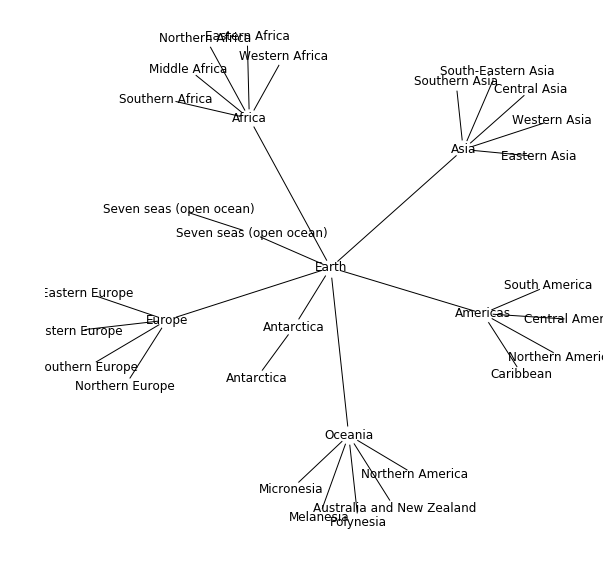

In [21]:
World = nx.Graph()
labels = {}

World.add_node(0,kind="root",name="Earth")
labels[0] = "Earth"

index = max(list(World.nodes))+1

#for c in worlddata.REGION_UN.unique():
for c in map_unitsdata.REGION_UN.unique():
    World.add_node(index,kind="continent",name=c)
    World.add_edge(0,index,kind="containsPlace")
    labels[index] = c
    index += 1
    
index = max(list(World.nodes))+1

for i,row in map_unitsdata[["REGION_UN","SUBREGION"]].drop_duplicates().iterrows():
    region_un = find_node_by_attribute_value(World,"name",row["REGION_UN"],kind="continent")
    World.add_node(index,kind="subregion",name=row["SUBREGION"])
    World.add_edge(region_un,index,kind="containsPlace")
    labels[index] = row["SUBREGION"]
    index += 1
    
    
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(World,with_labels=True,labels=labels,ax=ax,node_color="#FFFFFF")
plt.show()

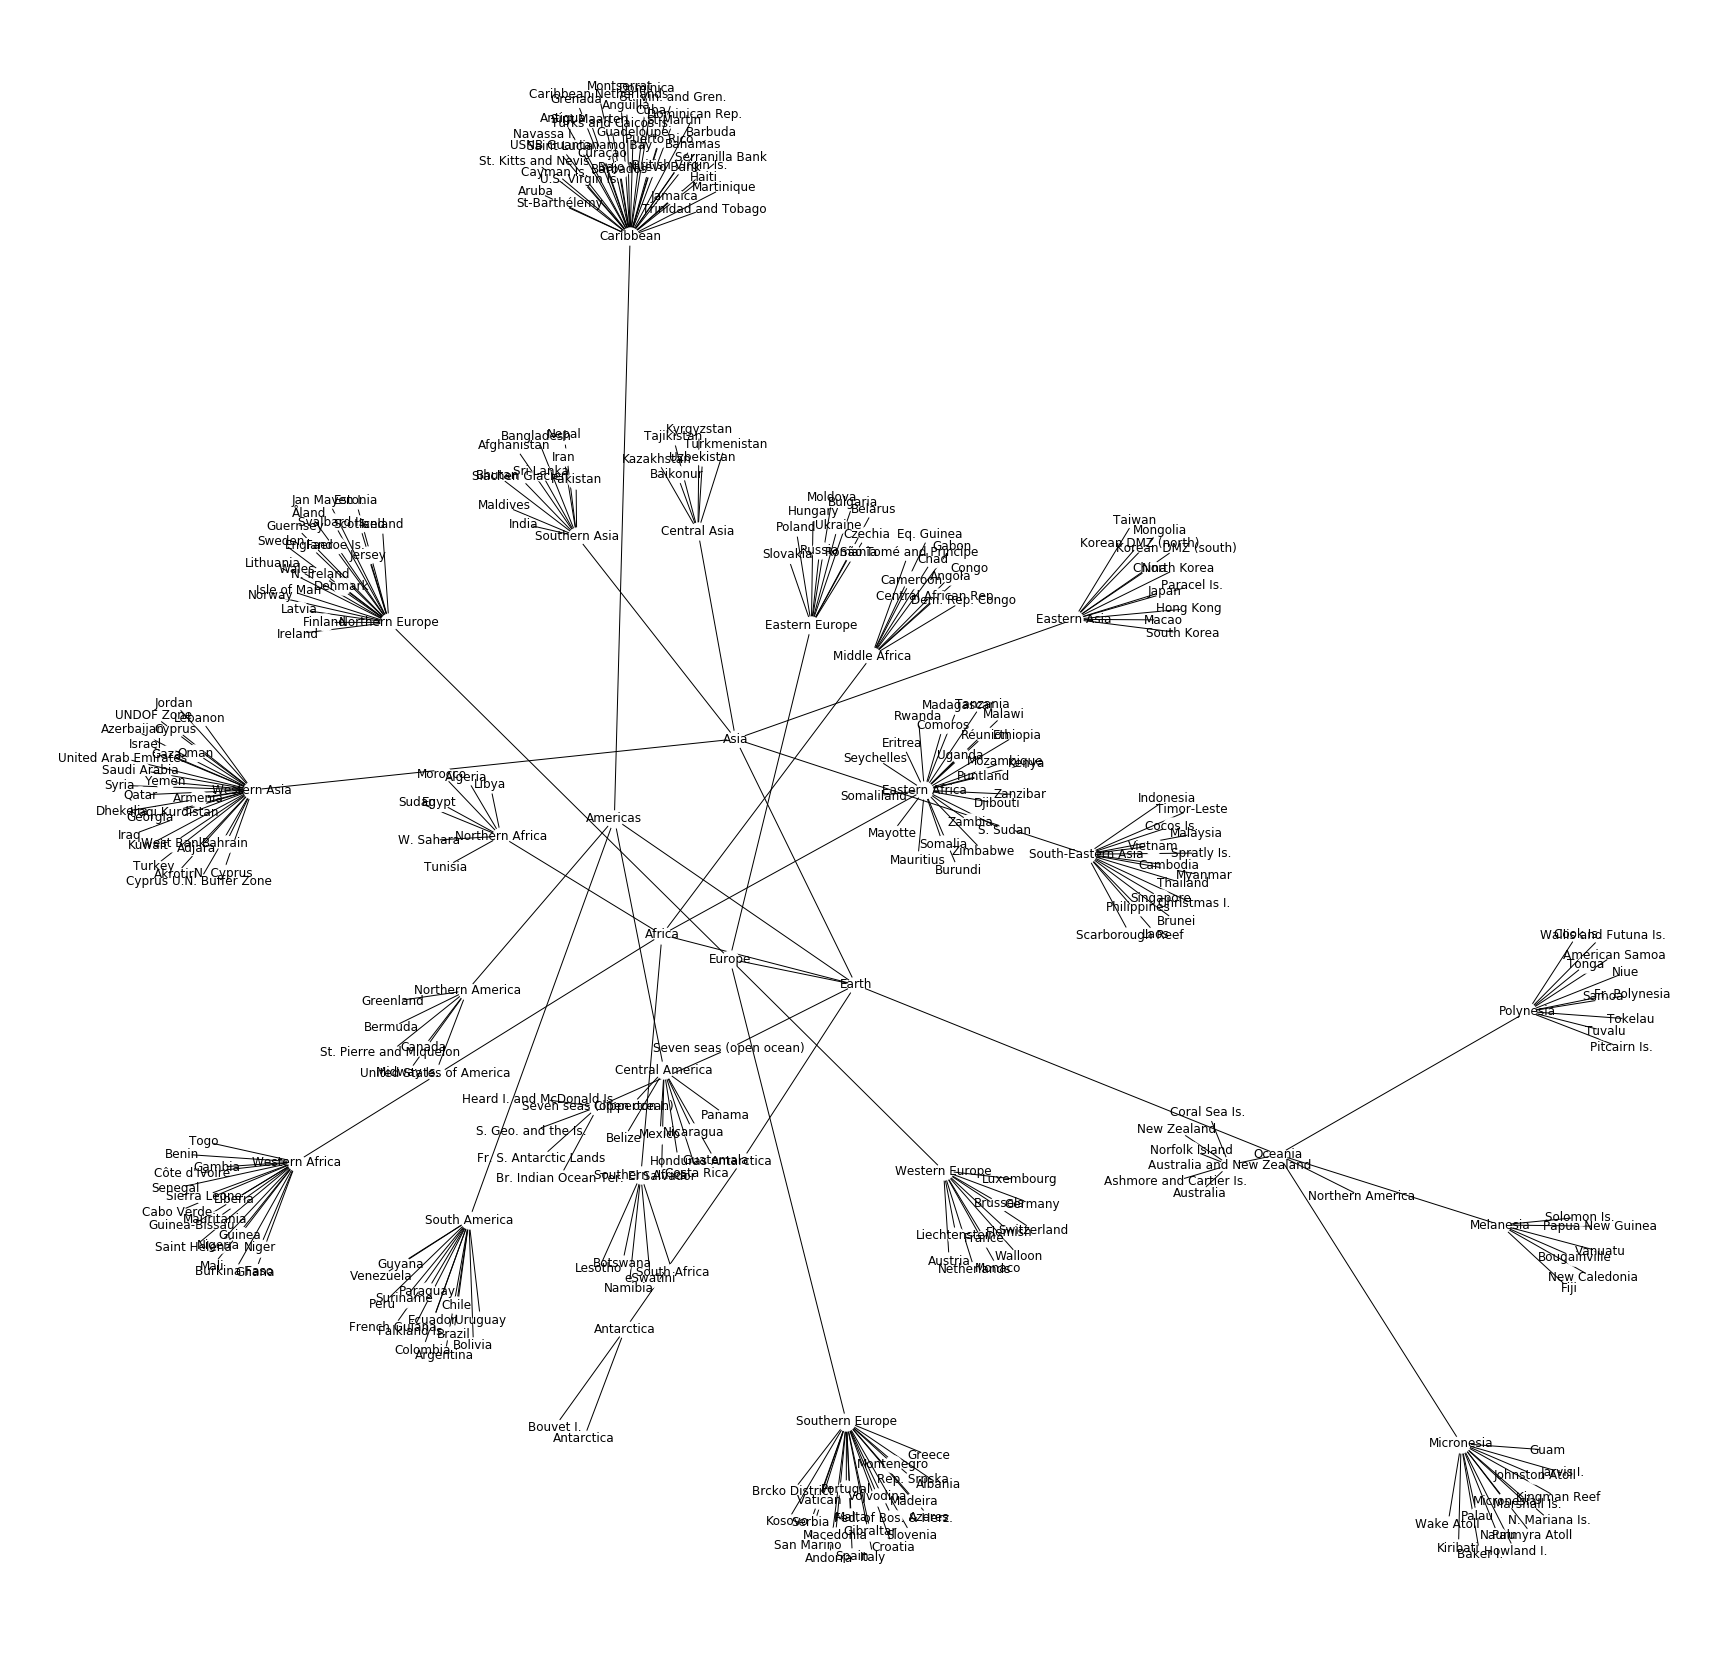

In [22]:
index = max(list(World.nodes))+1

for i,row in map_unitsdata.iterrows():
    subregion = find_node_by_attribute_value(World,"name",row["SUBREGION"],kind="subregion")
    World.add_node(index,admin=row["ADMIN"],iso_a3=row["ISO_A3"],adm0_a3=row["ADM0_A3"],
                   identifier=row["SOV_A3"],formal=row["FORMAL_EN"],name=row["NAME"],kind="sovereignity")
    World.add_edge(subregion,index,kind="containsPlace")
    #labels[index] = row["ADM0_A3"]
    labels[index] = row["NAME"]
    index += 1
    
fig,ax = plt.subplots(figsize=(30,30))
nx.draw(World,with_labels=True,labels=labels,ax=ax,node_color="#FFFFFF")
plt.show()    

In [24]:
FIELD = "NAME"
key = "name"

compute_1 = 0.
compute_2 = 0.
compute_3 = 0.

#for index, row in worlddata[["ADM0_A3","geometry"]].iterrows():
ddf = map_unitsdata[[FIELD,"geometry"]]
for index, row in ddf.iterrows():   
    # get 'not disjoint' countries
    #neighbours = worlddata[~worlddata.geometry.disjoint(row.geometry)][FIELD].tolist()
    s = time.time()
    neighbours = ddf[~ddf.geometry.disjoint(row.geometry)][FIELD].tolist()
    e = time.time()
    compute_1 += e-s
    # remove own name from the list
    s = time.time()
    neighbours = [ field for field in neighbours if row[FIELD] != field ]
    e = time.time()
    compute_2 += e-s

    my_country = find_node_by_attribute_value(World,key,row[FIELD],kind="sovereignity")

    s = time.time()
    for n in neighbours:
        other_country = find_node_by_attribute_value(World,key,n,kind="sovereignity")
        World.add_edge(my_country,other_country,kind="geoTouches")
        #print(my_country,other_country,end="..")
    e = time.time()
    compute_3 += e-s

compute_1,compute_2,compute_3

(89.38614702224731, 0.0241549015045166, 0.03693127632141113)

In [25]:
Path("/project_data/data_asset/mercury/geo/").mkdir(parents=True, exist_ok=True)
with open("/project_data/data_asset/mercury/geo/world-graph.json","w+t") as outfile:
    outfile.write(json.dumps(nx.readwrite.json_graph.node_link_data(World),indent=3))

Export into graphml so one can use yWorks' fabulous [yEd](https://www.yworks.com/products/yed) to lay out the graph. Note that, in yEd, one needs to map attributes to be displayed.

In [26]:
attributes = set()

for i in World.nodes:
    for k in World.nodes[i].keys():
        attributes.add(k)

World_for_export_to_graphml = World.copy()

for a in attributes:
    for k,v in nx.get_node_attributes(World_for_export_to_graphml,a).items():
        if type(v) == type(None):
            nx.set_node_attributes(World_for_export_to_graphml,{k:{a:""}})

nx.write_graphml(World_for_export_to_graphml,"/project_data/data_asset/mercury/geo/world-graph.graphml")

In [27]:
def find_edges_of_kind(graph,kind):
    return [(u,v) for u,v,d in graph.edges(data=True) if d['kind']==kind]

def find_edges_of_key_value(graph,key,value):
    retval = []
    for edge in graph.edges:
        edge_dict = graph.edges[edge]
        print(edge,edge_dict)
        if edge_dict.get(key) is None:
            pass
        elif edge_dict.get(key) == value:
            retval.append(edge)
            #print(edge)
    return retval

def find_nodes_of_kind(graph,kind):
    return [u for u,d in graph.nodes(data=True) if d['kind']==kind]

def find_nodes_of_key_value(graph,key,value):
    retval = []
    for node in graph.nodes:
        node_dict = graph.nodes[node]
        #print(node,node_dict)
        if node_dict.get(key) is None:
            pass
        elif node_dict.get(key) == value:
            retval.append(node)
            #print(node)
    return retval

def create_subgraph_of_nodes(graph,nodes,edges):
    #nodes = find_nodes_of_kind(graph,kind_nodes)
    #edges = find_edges_of_kind(graph,kind_edges)
    return nx.restricted_view(graph,set(graph.nodes).difference(list(nodes)),set(graph.edges).difference(list(edges))).copy()
    
    
neighbour_edges = [(u,v) for u,v,d in World.edges(data=True) if d['kind']=='geoTouches']

country_nodes = [u for u,d in World.nodes(data=True) if d['kind']=="sovereignity"]

# This is tricky, restricted view filters *out* the nodes and edges but we want them *in*
Neighbours = nx.restricted_view(World,set(World.nodes).difference(list(country_nodes)),set(World.edges).difference(list(neighbour_edges))).copy()

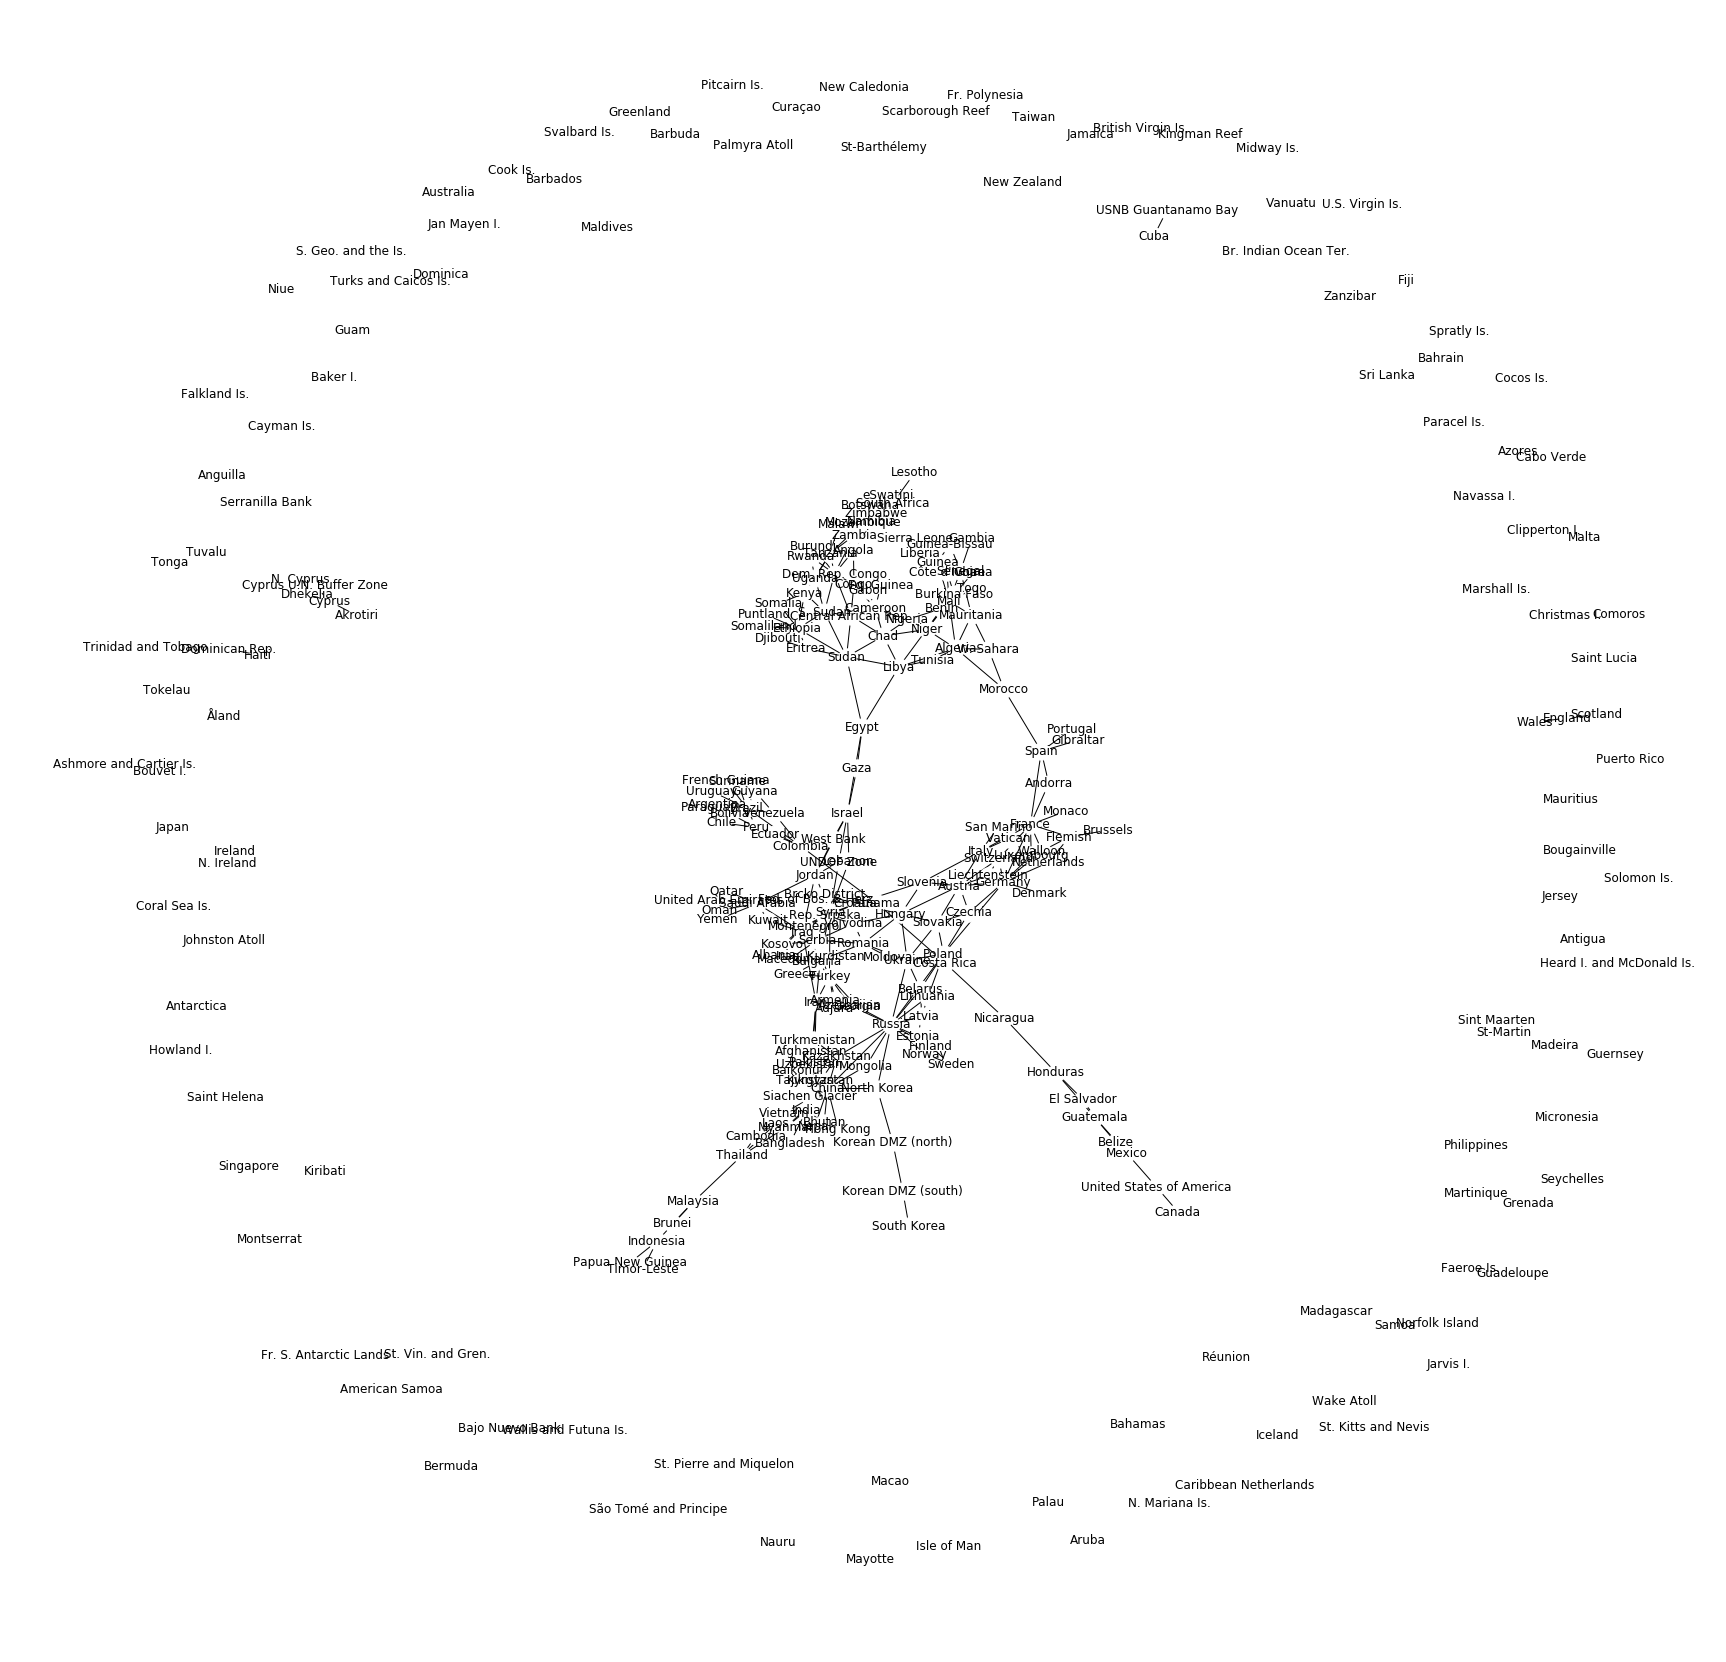

In [44]:
fig,ax = plt.subplots(figsize=(30,30))
mylabels = { k: labels[k] for k in list(Neighbours.nodes) } # another trick, apparently NetworkX does not like label dicts with extra keys
#pos = nx.draw_shell(Neighbours,with_labels=True,labels=mylabels)
#nx.draw(Neighbours,pos,ax=ax,node_color="#FFFFFF")
nx.draw(Neighbours,with_labels=True,labels=mylabels,ax=ax,node_color="#FFFFFF")
plt.show()    

Examples on how to call the helper functions. This is looking for Germany and its neighbour countries.

In [29]:
find_nodes_of_key_value(World,"adm0_a3","DEU")

[86]

In [32]:
#def geoTouches_name(name1,name2):
n = find_nodes_of_key_value(World,"adm0_a3","DEU")[0]
e = find_edges_of_kind(World,'geoTouches')

for c in e:
    if c[0] == n:
        print(World.nodes[c[1]])
    elif c[1] == n:
        print(World.nodes[c[0]])

{'admin': 'Czechia', 'iso_a3': 'CZE', 'adm0_a3': 'CZE', 'identifier': 'CZE', 'formal': 'Czech Republic', 'name': 'Czechia', 'kind': 'sovereignity'}
{'admin': 'Luxembourg', 'iso_a3': 'LUX', 'adm0_a3': 'LUX', 'identifier': 'LUX', 'formal': 'Grand Duchy of Luxembourg', 'name': 'Luxembourg', 'kind': 'sovereignity'}
{'admin': 'France', 'iso_a3': 'FRA', 'adm0_a3': 'FRA', 'identifier': 'FR1', 'formal': 'Metropolitan France', 'name': 'France', 'kind': 'sovereignity'}
{'admin': 'Belgium', 'iso_a3': '-99', 'adm0_a3': 'BEL', 'identifier': 'BEL', 'formal': 'Waals Gewest', 'name': 'Walloon', 'kind': 'sovereignity'}
{'admin': 'Denmark', 'iso_a3': 'DNK', 'adm0_a3': 'DNK', 'identifier': 'DN1', 'formal': 'Kingdom of Denmark', 'name': 'Denmark', 'kind': 'sovereignity'}
{'admin': 'Poland', 'iso_a3': 'POL', 'adm0_a3': 'POL', 'identifier': 'POL', 'formal': 'Republic of Poland', 'name': 'Poland', 'kind': 'sovereignity'}
{'admin': 'Austria', 'iso_a3': 'AUT', 'adm0_a3': 'AUT', 'identifier': 'AUT', 'formal': '